In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io
import sklearn.model_selection as skl
from itertools import chain
from random import sample

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
46154,00011813_000.png,No Finding,0,11813,38,F,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00011813_000.png
61373,00015151_001.png,Pleural_Thickening,1,15151,86,F,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00015151_001.png
85577,00021106_000.png,No Finding,0,21106,49,F,PA,2818,2729,0.143,0.143,NaN,/data/images_010/images/00021106_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels=[x for x in all_labels if len(x)>0]
print(all_labels)

for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Checking pneumonia value counts
all_xray_df["Pneumonia"].value_counts()

0.0    110689
1.0      1431
Name: Pneumonia, dtype: int64

In [5]:
all_xray_df[all_xray_df["Pneumonia"]==1]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7,30536,56,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1,30570,29,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
111845,00030637_016.png,Consolidation|Pneumonia,16,30637,48,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


We extracted all values containing pneumonia (solo or in combination with other pathologies).

## Create your training and testing data:

In [6]:
train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Pneumonia'])

In [7]:
train_df['Pneumonia'].sum()/len(train_df)

0.012765340706386016

In [8]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.012754191937210132

## Creating a training set that has equal amount of pneumonia and no pneumonia classes

In [9]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [10]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [11]:
# Checking shapes
print(train_df.shape)

print(valid_df.shape)

(2290, 28)
(22424, 28)


In [12]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
IMG_SIZE=[224,224]
def my_image_augmentation(vargs):
    
    idg = ImageDataGenerator(rescale= 1. / 255.0,
                         horizontal_flip= True,
                         vertical_flip= False,
                         height_shift_range= 0.1,
                         width_shift_range= 0.1,
                         rotation_range= 20,
                         shear_range= 0.1,
                         zoom_range= 0.1)
    
    return idg


def make_train_gen(vargs):
    
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen= idg.flow_from_dataframe(dataframe=train_df, directory= None,
                             x_col = 'path',
                             y_col = 'Pneumonia',
                             class_mode = 'raw',
                             target_size = IMG_SIZE,       
                             batch_size = 32
                            )
    

    return train_gen


def make_val_gen(vargs):
    val_idg=ImageDataGenerator(rescale=1. / 255.0
                                 )
    
    val_gen= val_idg.flow_from_dataframe(dataframe=valid_df, directory= None,
                             x_col = 'path',
                             y_col = 'Pneumonia',
                             class_mode = "raw",
                             target_size = IMG_SIZE,       
                             batch_size = 32
                            )
    
    
    return val_gen

In [14]:
idg=my_image_augmentation(train_df)

In [15]:
train_gen= make_train_gen(train_df)

Found 2290 validated image filenames.


In [16]:
val_gen= make_val_gen(valid_df)

Found 1430 validated image filenames.


In [17]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

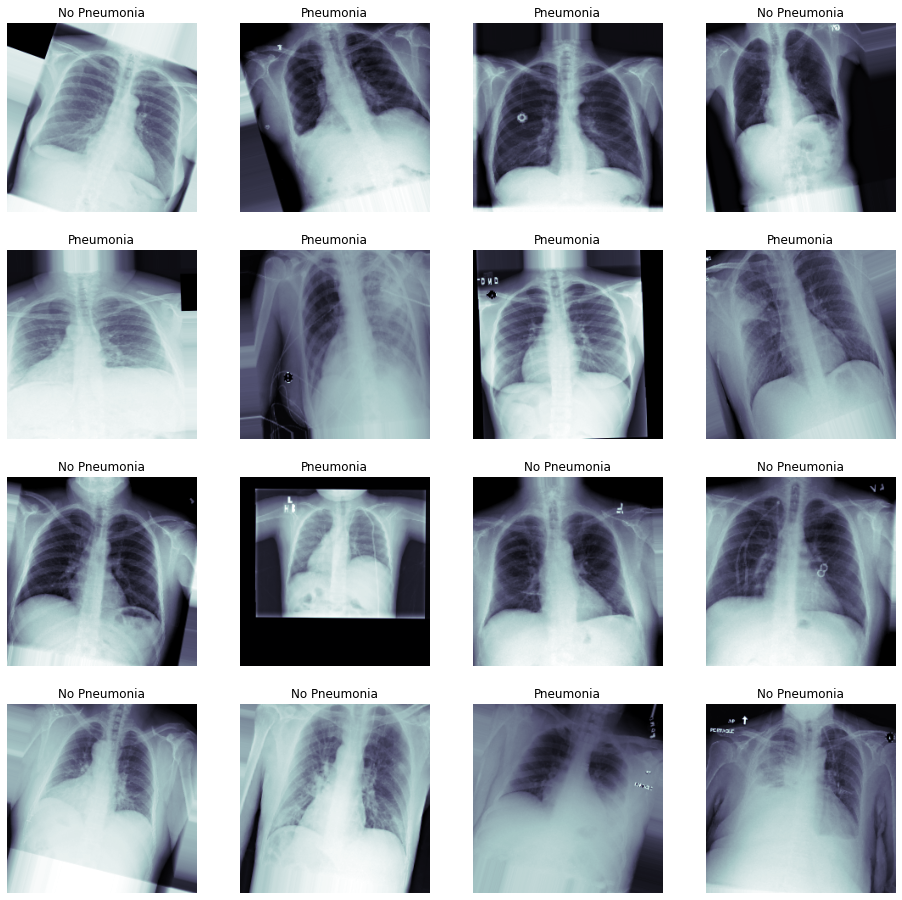

In [18]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [19]:
def load_pretrained_model():
    
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
   
    
    return vgg_model


In [20]:
def build_my_model(vgg_model):
    
    
   
    my_model = Sequential()
      
     # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)
    # Eg. freeze first 16 layers:

    for layer in vgg_model.layers[0:17]:
        
        layer.trainable= False
    # Adding new layers to our Vgg model:
    my_model.add(Flatten())
    #my_model.add(Dense(256,activation="relu"))
    #my_model.add(Dropout(0.2))
    #my_model.add(Dense(128,activation="relu"))
    my_model.add(Dense(1, activation="sigmoid"))             
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    
    
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [21]:
vgg_model= load_pretrained_model()

553467904/553467096 [==============================] - 10s 0us/step


In [22]:
model= build_my_model(vgg_model)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 2,384,897
Non-trainable params: 12,354,880
_________________________________________________________________


In [24]:
# set your optimizer, loss function, and metrics to monitor
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [25]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [26]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting



weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= "binary_accuracy", 
                              verbose=1, 
                              save_best_only=True, 
                              mode= "max", 
                              save_weights_only = True)

early = EarlyStopping(monitor= "binary_accuracy", 
                       mode= "max", 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [42]:
## train your model

history = model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 20, 
                           callbacks = callbacks_list)

Epoch 1/20
72/72 [==============================] - 63s 876ms/step - loss: 0.6532 - binary_accuracy: 0.5948 - val_loss: 0.7986 - val_binary_accuracy: 0.3438

Epoch 00001: binary_accuracy improved from -inf to 0.59476, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
72/72 [==============================] - 62s 862ms/step - loss: 0.6214 - binary_accuracy: 0.6555 - val_loss: 0.9268 - val_binary_accuracy: 0.3750

Epoch 00002: binary_accuracy improved from 0.59476 to 0.65546, saving model to xray_class_my_model.best.hdf5
Epoch 3/20
72/72 [==============================] - 63s 874ms/step - loss: 0.6185 - binary_accuracy: 0.6677 - val_loss: 0.7463 - val_binary_accuracy: 0.4062

Epoch 00003: binary_accuracy improved from 0.65546 to 0.66769, saving model to xray_class_my_model.best.hdf5
Epoch 4/20
72/72 [==============================] - 62s 855ms/step - loss: 0.6046 - binary_accuracy: 0.6672 - val_loss: 0.9216 - val_binary_accuracy: 0.4375

Epoch 00004: binary_accuracy did not improve

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [27]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 6s 189ms/step


In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import binarize

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score

# function to plot the roc_curve. You can utilize roc_curve and auc imported above
def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return precision, recall, thresholds

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history,epoch):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,12))
    plt.style.use('ggplot')
    plt.plot(range(epoch),history.history['loss'],label='Loss', color='green')
    plt.plot(range(epoch),history.history['val_loss'],label='Validation_Loss', color = 'red')
    plt.plot(range(epoch),history.history['binary_accuracy'],label='Binary_Accuracy',color='blue')
    plt.plot(range(epoch),history.history['val_binary_accuracy'],label='Validation_Bin_Accuracy',color='purple')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    
    plt.show()

    return

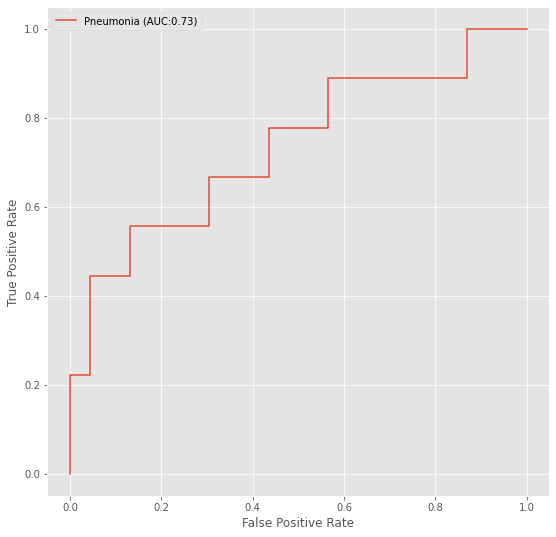

In [43]:
plt.style.use('ggplot')
plot_roc_curve(valY,pred_Y)

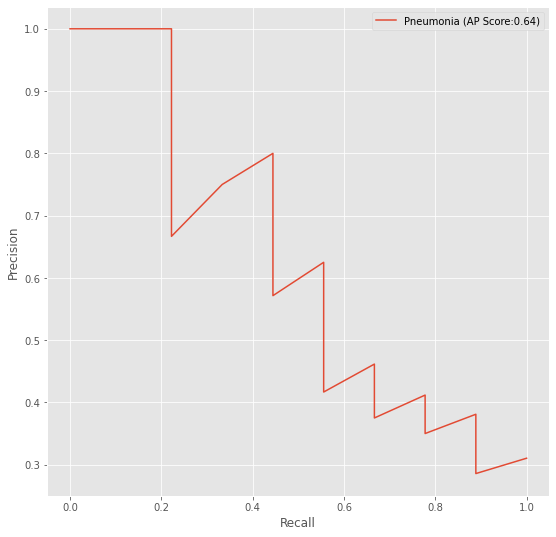

In [73]:
precision, recall, thresholds= plot_precision_recall_curve(valY,pred_Y)

In [54]:
def plot_f1(t_y,p_y):
    precision, recall, threshold = plot_precision_recall_curve(t_y,p_y)
    f1 = calc_f1(precision, recall)
    plt.style.use('ggplot')
    plt.plot(threshold, f1)
    plt.title('F1 vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    plt.savefig('out/F1_Threshold')
    plt.show()
    
    return precision, recall, f1, threshold

In [77]:
f1 = calc_f1(precision, recall)

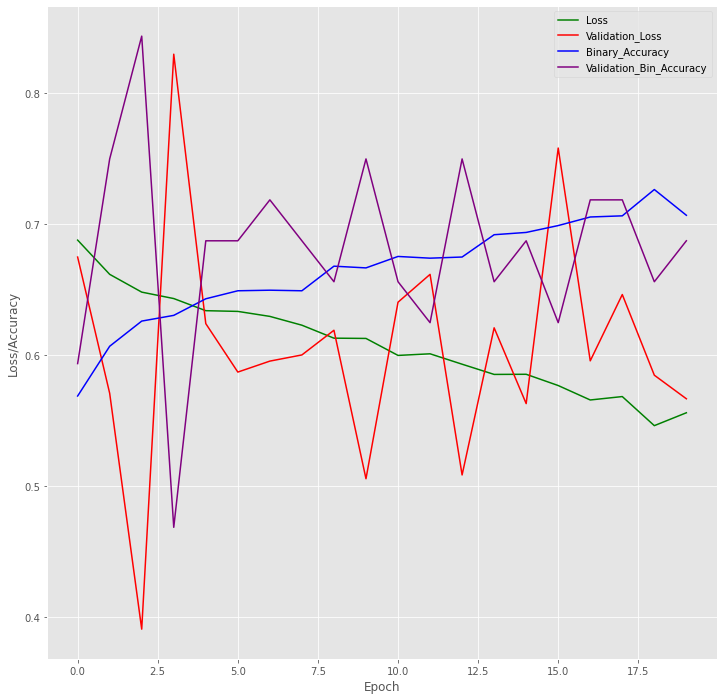

In [35]:
plot_history(history,20)